## Component 3 

### Module Installation

### Implementation

In [2]:
# Import the libraries
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as Bk

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score

In [3]:
train_dataset = pd.read_csv('./Emergency_Vehicles/train.csv')
test_dataset = pd.read_csv('./Emergency_Vehicles/test.csv')
train_dataset.head()

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


In [4]:
train_dataset.shape[0]

1646

In [5]:
train_dataset['emergency_or_not'] = train_dataset['emergency_or_not'].astype(str)
train_dataset.head()

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


In [6]:
train_dir = r'./Emergency_Vehicles/train'
test_dir = r'./Emergency_Vehicles/test'

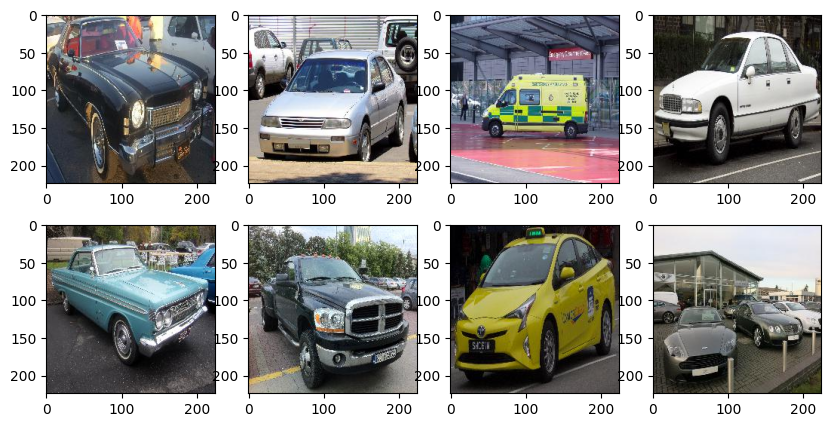

In [7]:
%matplotlib inline

sample_class = os.listdir(train_dir)

fig = plt.figure(figsize=(10,5))
for i in range(len(sample_class[:8])):
    plt.subplot(2,4,i+1)
    img = plt.imread(os.path.join(train_dir,sample_class[i]))
    plt.imshow(img, cmap=plt.get_cmap('gray'))

In [8]:
sample_img = cv2.imread(r'./Emergency_Vehicles/train/1.jpg')
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB) # converting to RGB

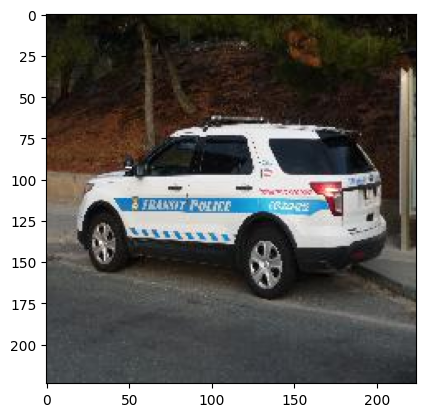

In [9]:
plt.imshow(sample_img)

In [10]:
#Define the image width and height to feed to a data generator 
sample_width = sample_img.shape[0]
sample_height = sample_img.shape[1]

# Initialize the batch size and the number of epoch/episodes.
batch_size = 40
epoch = 10

### Preprocessing 

In [11]:
# Applying our data transformations using ImageDataGenerators
trainimg_gen = ImageDataGenerator(
                            rotation_range= 20,
                            width_shift_range=0.1, 
                            height_shift_range=0.1,
                            shear_range=0.2, 
                            zoom_range=0.2,
                            fill_mode='nearest', 
                            horizontal_flip=True,
                            rescale= 1/255,
                            validation_split= 0.20
                            )

testimg_gen = ImageDataGenerator(rescale= 1/255)

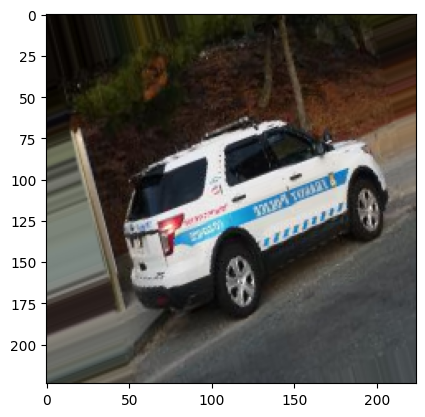

In [12]:
# showing the transformation
plt.imshow(trainimg_gen.random_transform(sample_img))

In [15]:

train_generator = trainimg_gen.flow_from_dataframe(
                                            dataframe= train_dataset,
                                            directory= train_dir,
                                            x_col= "image_names",
                                            y_col= "emergency_or_not",
                                            target_size= (sample_width, sample_height),
                                            batch_size= batch_size,
                                            class_mode= "binary",
                                            subset= 'training',
                                            shuffle= True,
                                            seed= 42
                                            )


valid_generator = trainimg_gen.flow_from_dataframe(
                                            dataframe= train_dataset,
                                            directory= train_dir,
                                            x_col= "image_names",
                                            y_col= "emergency_or_not",
                                            target_size= (sample_width, sample_height),
                                            batch_size= batch_size,
                                            class_mode= "binary",
                                            subset= 'validation',
                                            shuffle= True,
                                            seed= 42
                                            )


test_generator = testimg_gen.flow_from_dataframe(
                                            dataframe= test_dataset,
                                            directory= test_dir,
                                            x_col= "image_names",
                                            target_size= (sample_width, sample_height),
                                            batch_size= 1,
                                            class_mode= None,
                                            shuffle= False,
                                            )

Found 1317 validated image filenames belonging to 2 classes.
Found 329 validated image filenames belonging to 2 classes.
Found 706 validated image filenames.


### Model Architecture and Compilation.

#### Shallow Network Architecture

In [16]:
def define_model_architecture_2():
    # Initialize the model as a sequencial model
    model = Sequential()
    
    # Include a 2 Dimensional Convolutional layer with filters = 32, relu activation function and a kernel = (3,3)
    model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(sample_width, sample_height, 3)))
    
    # Include a max pooling layer with pool size = (2,2)
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Flatten the model
    model.add(Flatten())
    
    # Include a Dense layer with 64 unit and relu activation function
    model.add(Dense(16, activation='relu'))
    
    # Include a dropout layer at rate of 0.2
    model.add(Dropout(0.2))
    
    # Include an outer dense layer of 1 unit and a sigmoid activation function.
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model.
    model.compile(loss="binary_crossentropy",optimizer="adam",metrics=['accuracy'])
    
    return model

In [17]:
model_2 = define_model_architecture_2()
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 394272)            0         
                                                                 
 dense (Dense)               (None, 16)                6308368   
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                        

#### Training shallow model

In [18]:
model2_history = model_2.fit_generator(train_generator,
                            validation_data = valid_generator,
                            steps_per_epoch = train_generator.n//train_generator.batch_size,
                            validation_steps = valid_generator.n//valid_generator.batch_size,
                            epochs=epoch)

C:\Users\HP\AppData\Local\Temp\ipykernel_24056\2630149007.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model2_history = model_2.fit_generator(train_generator,


Epoch 1/10
32/32 [==============================] - 80s 2s/step - loss: 1.7931 - accuracy: 0.4808 - val_loss: 0.6928 - val_accuracy: 0.6000
Epoch 2/10
32/32 [==============================] - 58s 2s/step - loss: 0.6921 - accuracy: 0.5857 - val_loss: 0.6909 - val_accuracy: 0.6000
Epoch 3/10
32/32 [==============================] - 53s 2s/step - loss: 0.6908 - accuracy: 0.5803 - val_loss: 0.6887 - val_accuracy: 0.6125
Epoch 4/10
32/32 [==============================] - 55s 2s/step - loss: 0.6892 - accuracy: 0.5850 - val_loss: 0.6871 - val_accuracy: 0.6094
Epoch 5/10
32/32 [==============================] - 46s 1s/step - loss: 0.6884 - accuracy: 0.5787 - val_loss: 0.6859 - val_accuracy: 0.6031
Epoch 6/10
32/32 [==============================] - 47s 1s/step - loss: 0.6875 - accuracy: 0.5779 - val_loss: 0.6845 - val_accuracy: 0.6031
Epoch 7/10
32/32 [==============================] - 60s 2s/step - loss: 0.6863 - accuracy: 0.5803 - val_loss: 0.6833 - val_accuracy: 0.6031
Epoch 8/10
32/32 [==

#### Loss Graph of Shallow model

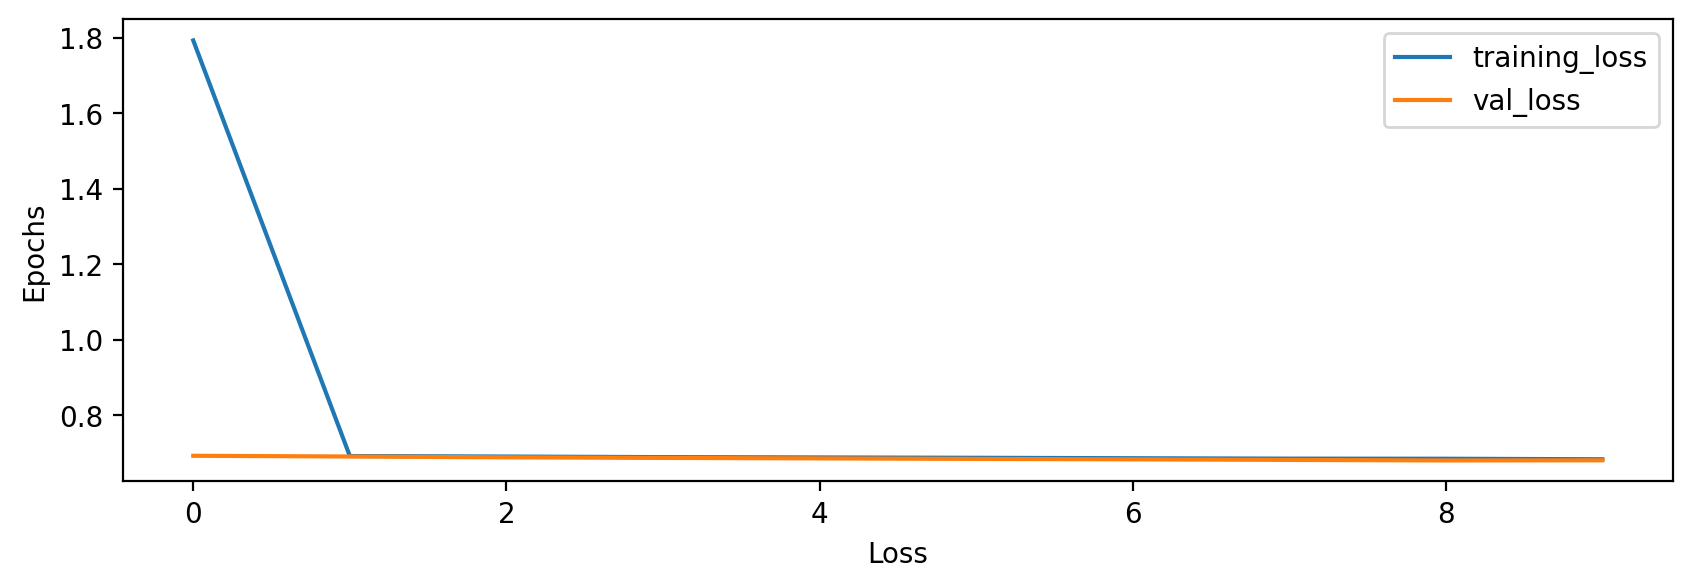

In [19]:
model2_historydf = pd.DataFrame(model2_history.history)
plt.figure(dpi=200, figsize = (10,3))
plt.plot(model2_historydf['loss'],
label='training_loss')
plt.plot(model2_historydf['val_loss'],
label='val_loss')
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.legend()
plt.show()

#### Evaluation of shallow network 

In [23]:
# Check the shallow nekwork accuracy.
shallow_score = model_2.evaluate(valid_generator)
print('Test loss:', shallow_score[0])
print('Test accuracy:', shallow_score[1])

9/9 [==============================] - 7s 767ms/step - loss: 0.6805 - accuracy: 0.6018
Test loss: 0.6805109977722168
Test accuracy: 0.6018236875534058


#### Prediction using the shallow network

In [53]:
imagenames = test_dataset['image_names'].to_list()

image_names = [name for name in imagenames if os.path.exists(os.path.join(test_dir, name))]

In [55]:
testimages = []
for name in image_names:
    # load the image
    img = cv2.imread(os.path.join(test_dir, name))

    # resize the image to the correct dimensions
    img = cv2.resize(img, (224, 224))
    
    # convert the image to floating point values in the range [0, 1]
    img = img.astype(np.float32) / 255.0

    # add the preprocessed image to the list
    testimages.append(img)
    
testimages = np.array(testimages)

In [44]:
# predict 
shallow_predict=model_2.predict(test_generator, steps = len(test_generator.filenames))
shallow_predict[:6] # show the probability of each class

706/706 [==============================] - 12s 17ms/step


array([[0.46190065],
       [0.46190065],
       [0.46190065],
       [0.46190065],
       [0.46190065],
       [0.46190065]], dtype=float32)

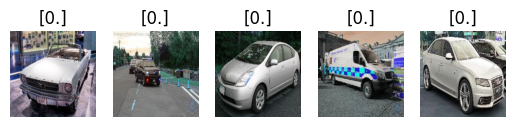

In [60]:
# round the predicted labels
shallow_predict = np.round(shallow_predict)

#Set the number of images per batch
testbatch_size = 5

# Get the predicted class labels for the current batch
shallowpredict_labels = shallow_predict[:testbatch_size]

# Get the corresponding images for the current batch
img = testimages[:testbatch_size]

# Create a figure with a grid of subplots
fig, axes = plt.subplots(1, testbatch_size)

# Loop through the subplots and plot the images

for i in range(testbatch_size):
    # Plot the image
    axes[i].imshow(img[i])
    axes[i].set_title(shallowpredict_labels[i])
    axes[i].axis('off')

# Show the figure
plt.show()

##### Summary

From the predictions, this shows that the model did not fit properly and got 2 of the 5 predictions wrong.

#### Exploring more layers to improve predictions.

#### Deep model Architecture.

In [33]:
def define_model_architecture():
    # Initialize the model as a sequencial model
    model = Sequential()
    
    # Include a 2 Dimensional Convolutional layer with filters = 32, relu activation function and a kernel = (3,3)
    model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(sample_width, sample_height, 3)))
    
    # Include a max pooling layer with pool size = (2,2)
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Include a second 2D Convolutional layer with filters = 64, relu activation function and a kernel = (3,3)
    model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
    
    # Include a second max pooling layer with pool size = (2,2)
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
     # Include a dropout layer at rate of 0.5
    model.add(Dropout(0.5))
    
    # Flatten the model
    model.add(Flatten())
    
    # Include a Dense layer with 64 unit and relu activation function
    model.add(Dense(64, activation='relu'))
    
    # Include a dropout layer at rate of 0.2
    model.add(Dropout(0.2))
    
    # Include an outer dense layer of 1 unit and a sigmoid activation function.
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model.
    model.compile(loss="binary_crossentropy",optimizer="adam",metrics=['accuracy'])
    
    return model

In [34]:
dmodel = define_model_architecture()
dmodel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 54, 54, 64)        0         
                                                                 
 flatten_2 (Flatten)         (None, 186624)           

#### Training deep Model

In [35]:
model_history = dmodel.fit(train_generator,
                    validation_data = valid_generator,
                    steps_per_epoch = train_generator.n//train_generator.batch_size,
                    validation_steps = valid_generator.n//valid_generator.batch_size,
                    epochs=epoch)

Epoch 1/10
32/32 [==============================] - 112s 3s/step - loss: 1.2113 - accuracy: 0.5959 - val_loss: 0.6608 - val_accuracy: 0.6531
Epoch 2/10
32/32 [==============================] - 98s 3s/step - loss: 0.6230 - accuracy: 0.6962 - val_loss: 0.5930 - val_accuracy: 0.6906
Epoch 3/10
32/32 [==============================] - 97s 3s/step - loss: 0.5775 - accuracy: 0.7150 - val_loss: 0.5483 - val_accuracy: 0.7531
Epoch 4/10
32/32 [==============================] - 117s 4s/step - loss: 0.5565 - accuracy: 0.7212 - val_loss: 0.5383 - val_accuracy: 0.7563
Epoch 5/10
32/32 [==============================] - 112s 3s/step - loss: 0.5222 - accuracy: 0.7580 - val_loss: 0.5442 - val_accuracy: 0.7531
Epoch 6/10
32/32 [==============================] - 112s 4s/step - loss: 0.5233 - accuracy: 0.7565 - val_loss: 0.5138 - val_accuracy: 0.7563
Epoch 7/10
32/32 [==============================] - 116s 4s/step - loss: 0.5290 - accuracy: 0.7494 - val_loss: 0.5621 - val_accuracy: 0.7437
Epoch 8/10
32/3

#### Loss graph of deep model

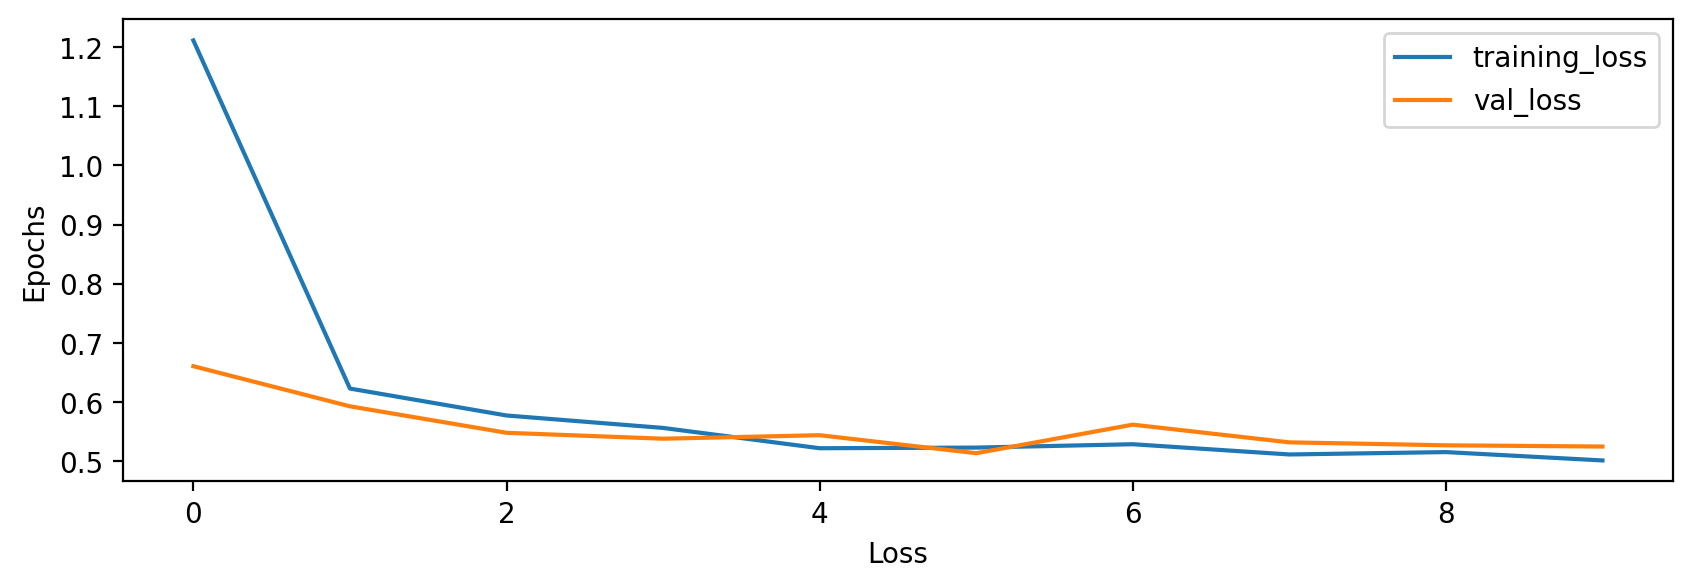

In [46]:
model_historydf = pd.DataFrame(model_history.history)
plt.figure(dpi=200, figsize = (10,3))
plt.plot(model_historydf['loss'],
label='training_loss')
plt.plot(model_historydf['val_loss'],
label='val_loss')
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.legend()
plt.show()

#### Evaluation of deep model

In [47]:
# Check the shallow nekwork accuracy.
deep_score = dmodel.evaluate(valid_generator)
print('Test loss:', deep_score[0])
print('Test accuracy:', deep_score[1])

9/9 [==============================] - 14s 1s/step - loss: 0.4917 - accuracy: 0.7599
Test loss: 0.49173805117607117
Test accuracy: 0.759878396987915


#### Prediction of deep model

In [49]:
deep_predict=dmodel.predict(test_generator, steps = len(test_generator.filenames))
deep_predict[:6] # show the probability of each class

706/706 [==============================] - 23s 32ms/step


array([[0.01261114],
       [0.7356285 ],
       [0.02124828],
       [0.9753839 ],
       [0.00115049],
       [0.6071159 ]], dtype=float32)

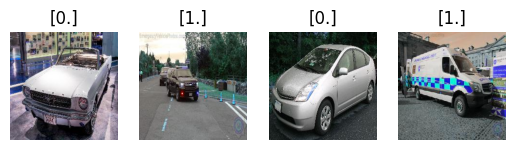

In [62]:
deep_predict = np.round(deep_predict)

#Set the number of images per batch
testbatch_size = 4

# Get the predicted class labels for the current batch
dpredict_labels = deep_predict[:testbatch_size]

# Get the corresponding images for the current batch
img = testimages[:testbatch_size]

# Create a figure with a grid of subplots
fig, axes = plt.subplots(1, testbatch_size)

# Loop through the subplots and plot the images

for i in range(testbatch_size):
    # Plot the image
    axes[i].imshow(img[i])
    axes[i].set_title(dpredict_labels[i])
    axes[i].axis('off')

# Show the figure
plt.show()

##### Summary

Prediction in the deeper layered model is more accurate with the predictions than in the shallow layer model.

In [ ]:
# TODO
# 1. Evaluation methods needed (classification report and confusion matrix)
# 2. improve the accuracy
# 3. Use pretrained network.